In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
pwd

'/kaggle/working'

In [3]:
dataset_path = '/kaggle/input/cnn-classifier'

In [4]:
extract_dataset_path = '/kaggle/input/cnn-classifier'

In [5]:
train_dataset_path = '/kaggle/input/cnn-classifier/cracks dataset/TRAIN DATA IMAGES'
validation_dataset_path = '/kaggle/input/cnn-classifier/cracks dataset/TEST DATA IMAGES'

In [6]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

In [7]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 585 images belonging to 4 classes.


In [8]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 214 images belonging to 4 classes.


In [9]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : diagonal images
1 : horizontal images
2 : structural images
3 : vertical images


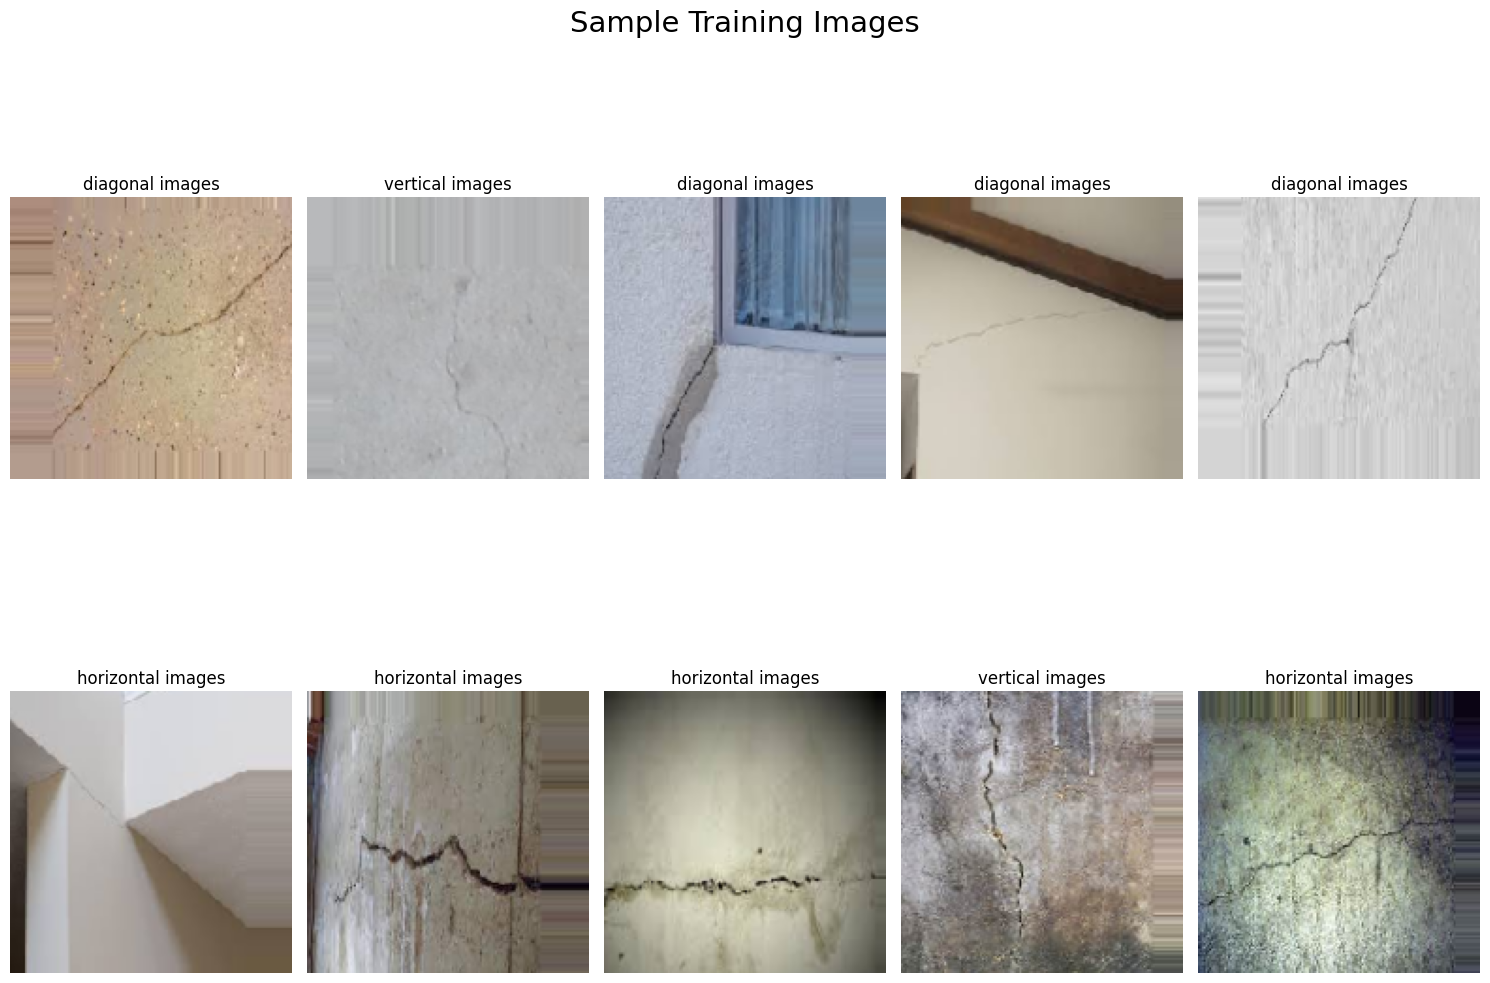

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [11]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=6, activation='softmax')
    ])
    
    return model

In [12]:
cnn_model = create_model()

In [13]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 128)     9728      
                                                                 
 activation (Activation)     (None, 146, 146, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 128)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 73, 73, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 71, 71, 64)        0

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [15]:
optimizer = Adam(learning_rate=0.001)

In [16]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [23]:
from sklearn.preprocessing import LabelEncoder

# Example data
categories = ['diagonal images', 'horizontal images', 'structural images', 'vertical images']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the categories to numerical labels
numerical_labels = label_encoder.fit_transform(categories)

# Print the mapping between categories and numerical labels
label_mapping = dict(zip(categories, numerical_labels))
print("Label Mapping:", label_mapping)


Label Mapping: {'diagonal images': 0, 'horizontal images': 1, 'structural images': 2, 'vertical images': 3}


In [25]:
categorical_labels = ['diagonal images', 'horizontal images', 'structural images', 'vertical images']


In [26]:
numerical_labels = [label_mapping[label] for label in categorical_labels]
print("Numerical Labels:", numerical_labels)


Numerical Labels: [0, 1, 2, 3]


In [27]:
from tensorflow.keras.utils import to_categorical

# Convert numerical labels to one-hot encoding
one_hot_labels = to_categorical(numerical_labels)
print("One-Hot Labels:\n", one_hot_labels)


One-Hot Labels:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [34]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Example data
categories = ['diagonal images', 'horizontal images', 'structural images', 'vertical images']

# Generate some dummy data for illustration purposes
num_samples = 585
image_shape = (28, 28, 1)
x_data = np.random.rand(num_samples, *image_shape)  
y_categorical = np.random.choice(categories, num_samples)  

# Convert categorical labels to numerical labels
label_encoder = LabelEncoder()
y_numerical = label_encoder.fit_transform(y_categorical)

# Convert numerical labels to one-hot encoding
y_one_hot = to_categorical(y_numerical)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_one_hot, test_size=0.2, random_state=42)

# Build a simple CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=image_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(categories), activation='softmax'))  # Output layer with the number of classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10  # Adjust the number of epochs as needed
model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')



Epoch 1/10
15/15 [==============================] - 1s 32ms/step - loss: 1.4575 - accuracy: 0.2628 - val_loss: 1.4165 - val_accuracy: 0.2735
Epoch 2/10
15/15 [==============================] - 0s 18ms/step - loss: 1.3775 - accuracy: 0.3034 - val_loss: 1.3897 - val_accuracy: 0.2735
Epoch 3/10
15/15 [==============================] - 0s 18ms/step - loss: 1.3572 - accuracy: 0.3056 - val_loss: 1.3936 - val_accuracy: 0.2735
Epoch 4/10
15/15 [==============================] - 0s 22ms/step - loss: 1.3311 - accuracy: 0.3056 - val_loss: 1.3923 - val_accuracy: 0.2735
Epoch 5/10
15/15 [==============================] - 0s 19ms/step - loss: 1.3029 - accuracy: 0.3312 - val_loss: 1.4119 - val_accuracy: 0.2735
Epoch 6/10
15/15 [==============================] - 0s 19ms/step - loss: 1.2447 - accuracy: 0.5107 - val_loss: 1.3869 - val_accuracy: 0.2735
Epoch 7/10
15/15 [==============================] - 0s 19ms/step - loss: 1.1860 - accuracy: 0.4701 - val_loss: 1.4154 - val_accuracy: 0.2479
Epoch 8/10
15

In [35]:
# Assuming you have trained your model like this
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

# Accessing training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Now you can use these variables for analysis or plotting


Epoch 1/10
15/15 [==============================] - 0s 25ms/step - loss: 0.8436 - accuracy: 0.8632 - val_loss: 1.4381 - val_accuracy: 0.3077
Epoch 2/10
15/15 [==============================] - 0s 19ms/step - loss: 0.7783 - accuracy: 0.8675 - val_loss: 1.4192 - val_accuracy: 0.2564
Epoch 3/10
15/15 [==============================] - 0s 19ms/step - loss: 0.6806 - accuracy: 0.9145 - val_loss: 1.4734 - val_accuracy: 0.2650
Epoch 4/10
15/15 [==============================] - 0s 19ms/step - loss: 0.5748 - accuracy: 0.9808 - val_loss: 1.5850 - val_accuracy: 0.2393
Epoch 5/10
15/15 [==============================] - 0s 19ms/step - loss: 0.4735 - accuracy: 0.9765 - val_loss: 1.5247 - val_accuracy: 0.2821
Epoch 6/10
15/15 [==============================] - 0s 20ms/step - loss: 0.3898 - accuracy: 0.9872 - val_loss: 1.7740 - val_accuracy: 0.2564
Epoch 7/10
15/15 [==============================] - 0s 19ms/step - loss: 0.3258 - accuracy: 0.9915 - val_loss: 1.5990 - val_accuracy: 0.2735
Epoch 8/10
15

In [37]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate schedule
def lr_schedule(epoch):
    """
    Returns a learning rate based on the epoch number.
    You can customize this function according to your needs.
    """
    initial_lr = 0.001
    decay_factor = 0.9
    decay_step = 5
    lr = initial_lr * (decay_factor ** (epoch // decay_step))
    return lr

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model with the callback
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), callbacks=[lr_scheduler])

# Accessing training history including learning rate
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
learning_rate = [lr_schedule(epoch) for epoch in range(epochs)]


Epoch 1/10
15/15 [==============================] - 0s 23ms/step - loss: 0.1488 - accuracy: 1.0000 - val_loss: 1.6820 - val_accuracy: 0.2564 - lr: 0.0010
Epoch 2/10
15/15 [==============================] - 0s 19ms/step - loss: 0.1253 - accuracy: 1.0000 - val_loss: 1.8106 - val_accuracy: 0.2479 - lr: 0.0010
Epoch 3/10
15/15 [==============================] - 0s 18ms/step - loss: 0.1016 - accuracy: 1.0000 - val_loss: 1.7450 - val_accuracy: 0.2564 - lr: 0.0010
Epoch 4/10
15/15 [==============================] - 0s 18ms/step - loss: 0.0853 - accuracy: 1.0000 - val_loss: 1.8599 - val_accuracy: 0.2479 - lr: 0.0010
Epoch 5/10
15/15 [==============================] - 0s 18ms/step - loss: 0.0703 - accuracy: 1.0000 - val_loss: 1.8440 - val_accuracy: 0.2564 - lr: 0.0010
Epoch 6/10
15/15 [==============================] - 0s 18ms/step - loss: 0.0616 - accuracy: 1.0000 - val_loss: 1.8518 - val_accuracy: 0.2650 - lr: 9.0000e-04
Epoch 7/10
15/15 [==============================] - 0s 19ms/step - loss:

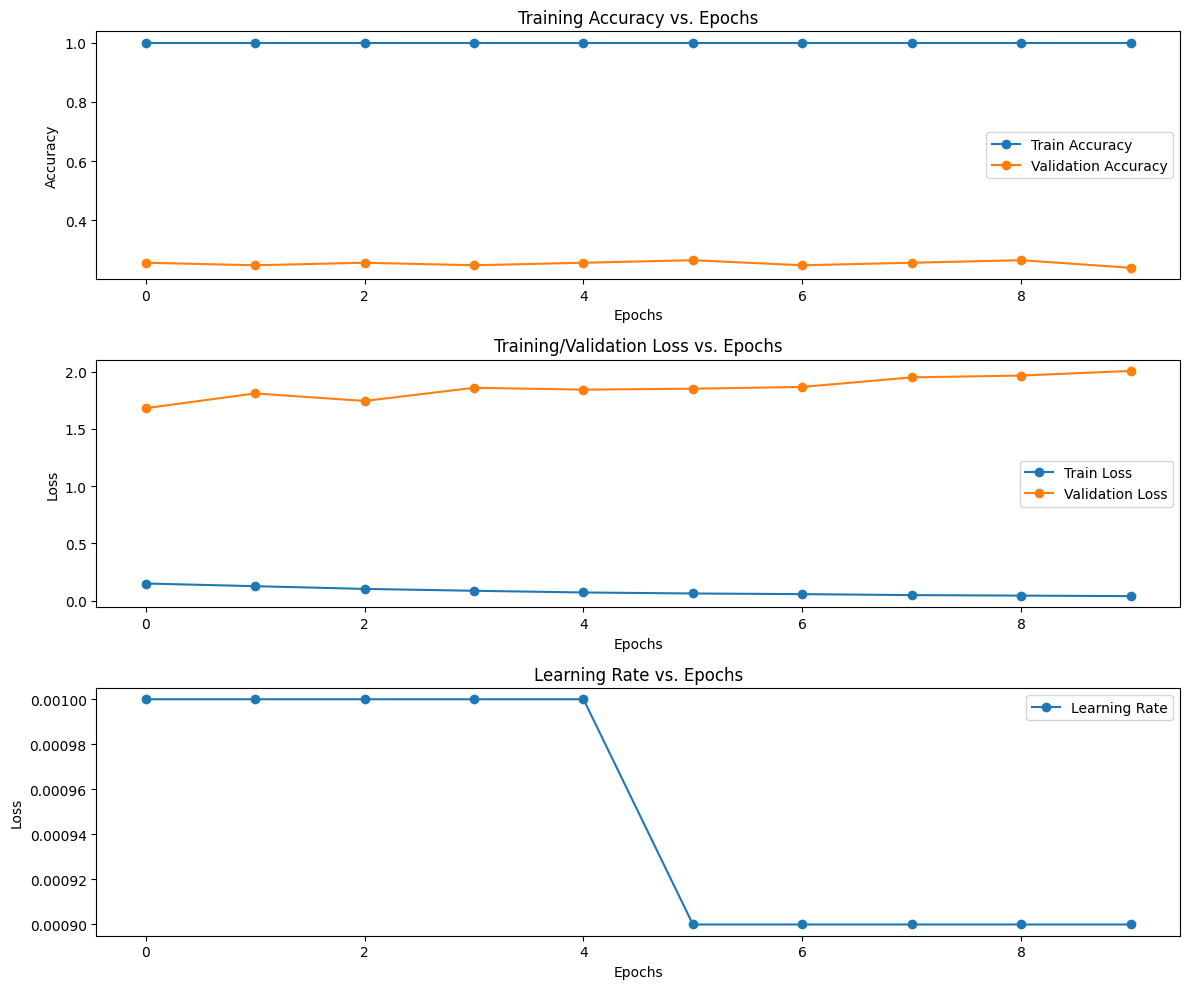

In [38]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [39]:
test_dataset = '/kaggle/input/cnn-classifier/cracks dataset/TEST DATA IMAGES'

In [40]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 214 images belonging to 4 classes.


In [41]:
predictions = cnn_model.predict(test_generator)

7/7 [==============================] - 13s 2s/step


KeyError: 5

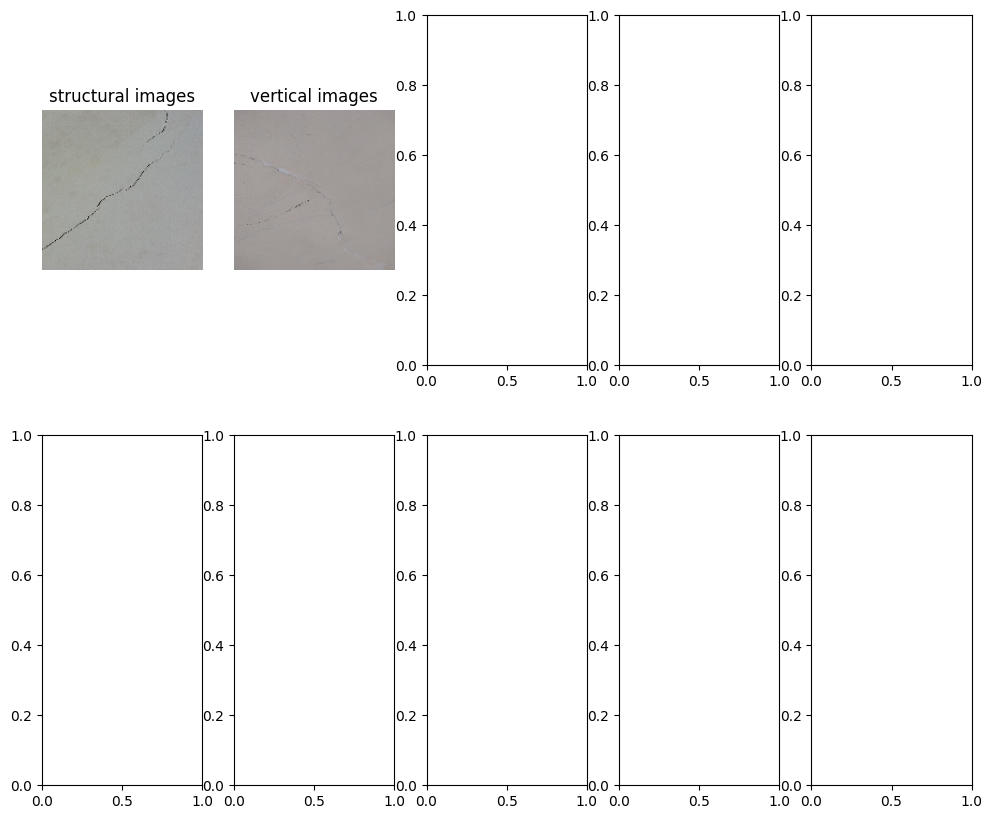

In [53]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        if idx < len(predictions):
            predicted_label = labels[np.argmax(predictions[idx])]
            ax[i, j].set_title(f"{predicted_label}")
            ax[i, j].imshow(test_generator[0][0][idx])
            ax[i, j].axis("off")
            idx += 1
        else:
            # Handle the case where there are no more predictions
            ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()




InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_42/2329760701.py", line 1, in <module>
      test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2200, in evaluate
      logs = test_function_runner.run_step(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 4000, in run_step
      tmp_logs = self._function(dataset_or_iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1972, in test_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1956, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1944, in run_step
      outputs = model.test_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1852, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/losses.py", line 2122, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/backend.py", line 5566, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[32,6] labels_size=[32,4]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_test_function_23694]